In [1]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt

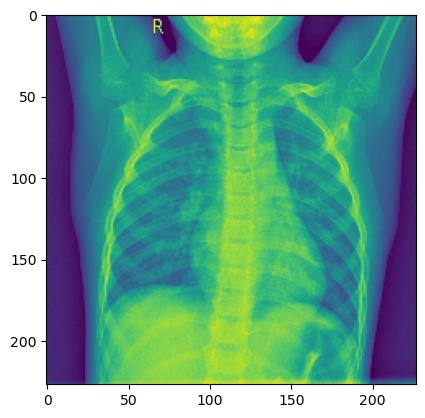

In [7]:
IMG_PATH = r'D:\My\University\Nam2\Kì 1\HocMayThongKe\ThucHanh\slide\03_PhanLoai\chest_xray\chest_xray\train\NORMAL\IM-0115-0001.jpeg'
IMG_SIZE = 227 
img = plt.imread(IMG_PATH)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
plt.imshow(img)
plt.show()


In [8]:
import numpy as np
img = np.asarray(img)
print(img.shape)

(227, 227)


In [28]:
import glob
PATH = r'D:\My\University\Nam2\Kì 1\HocMayThongKe\ThucHanh\slide\03_PhanLoai\chest_xray\chest_xray\train'
def load_data(path):
    X = np.array([])
    y = np.array([])
    classes = ['NORMAL', 'PNEUMONIA']
    for i in classes:
        files = glob.glob(path + '\\' + i + '\\*.jpeg')
        for f in files:
            img = plt.imread(f)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            if len(img.shape) == 2:
                img = np.stack((img,)*3, axis=-1)
            if X.size == 0:
                X = np.array([img])
            else:
                X = np.vstack([X, [img]])
            y = np.append(y, i)
    return X, y


In [32]:
X_train, y_train = load_data(PATH)

In [34]:
print(X_train.shape)
print(y_train.shape)

(5216, 227, 227, 3)
(5216,)


In [30]:
X_dev, y_dev = load_data(PATH.replace('train', 'val'))
X_test, y_test = load_data(PATH.replace('train', 'test'))
print(X_dev.shape)
print(X_test.shape)


(16, 227, 227, 3)
(624, 227, 227, 3)


In [35]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y_train)
X1 = X_train.reshape(X_train.shape[0], IMG_SIZE*IMG_SIZE*3)
X2 = X_dev.reshape(X_dev.shape[0], IMG_SIZE*IMG_SIZE*3)
X3 = X_test.reshape(X_test.shape[0], IMG_SIZE*IMG_SIZE*3)

y1 = le.transform(y_train)
y2 = le.transform(y_dev)
y3 = le.transform(y_test)

print(X1.shape)
print(X2.shape)
print(X3.shape)




(5216, 154587)
(16, 154587)
(624, 154587)


In [55]:
from numba import jit, cuda 
@jit(target_backend='cuda')
def sigmoid(x):
    return 1/(1 + np.exp(-x))
@jit(target_backend='cuda')
def loss(w, b):
    z = np.dot(X1, w) + b
    h = sigmoid(z)
    J = -np.sum(y1*np.log(h) + (1-y1)*np.log(1-h))/X1.shape[0]
    return J

@jit(target_backend='cuda')
def gradient_descent(X1, y, alpha, num_iter):
    w = np.zeros(X1.shape[1])
    b = 0
    for _ in range(num_iter):
        y_hat = sigmoid(np.dot(X1, w) + b)
        w = w - alpha * np.dot(X1.T, (y_hat - y))
        b = b - alpha * np.sum(y_hat - y)
        if _ % 100 == 0:
            print(loss(w, b))
        print(_)
    return w, b

w, b = gradient_descent(X1, y1, 0.02, 500)


C:\Users\Admin\AppData\Local\Temp\ipykernel_16956\2846320390.py:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(target_backend='cuda')
C:\Users\Admin\AppData\Local\Temp\ipykernel_16956\2846320390.py:5: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(target_backend='cuda')
C:\Users\Admin\AppData\Local\Temp\ipykernel_16956\2846320390.py:12: NumbaDeprecati

nan
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
nan
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
nan
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
27

In [44]:
from numba import jit, cuda 
import numpy as np 
# to measure exec time 
from timeit import default_timer as timer    
  
# normal function to run on cpu 
def func(a):                                 
    for i in range(10000000): 
        a[i]+= 1      
  
# function optimized to run on gpu  
@jit(target_backend='cuda')                          
def func2(a): 
    for i in range(10000000): 
        a[i]+= 1
if __name__=="__main__": 
    n = 10000000                            
    a = np.ones(n, dtype = np.float64) 
      
    start = timer() 
    func(a) 
    print("without GPU:", timer()-start)     
      
    start = timer() 
    func2(a) 
    print("with GPU:", timer()-start) 

C:\Users\Admin\AppData\Local\Temp\ipykernel_16956\2031428930.py:12: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(target_backend='cuda')


without GPU: 3.4111538999986806
with GPU: 1.934510200000659


In [52]:
def predict(X, w, b):
    z = np.dot(X, w) + b
    h = sigmoid(z)
    return h

def score(X, y, w, b):
    y_hat = predict(X, w, b)
    y_hat = np.where(y_hat > 0.5, 1, 0)
    return np.sum(y_hat == y)/y.shape[0]

print(score(X2, y2, w, b))
print(score(X3, y3, w, b))

0.625
0.657051282051282


In [53]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=0)
model.fit(X1, y1)

y_pred = model.predict(X3)



c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.7323717948717948
Precision: 0.7045871559633028
Recall: 0.9846153846153847
F1-micro: 0.8213903743315508
F1-macro: 0.6439220242264783


In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_pred = predict(X3, w, b)

print("Accuracy: " + str(accuracy_score(y3, y_pred)))
print("Precision: " + str(precision_score(y3, y_pred)))
print("Recall: " + str(recall_score(y3, y_pred)))
print("F1-micro: " + str(f1_score(y3, y_pred)))
print("F1-macro: " + str(f1_score(y3, y_pred, average='macro')))


Accuracy: 0.657051282051282
Precision: 0.6461794019933554
Recall: 0.9974358974358974
F1-micro: 0.784274193548387
F1-macro: 0.4741683467741935
